# Pure Heat Condution

Loading the modules and configurating:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import griddata

from deepxde.backend import tf
import deepxde as dde
dde.config.set_default_float("float64")
dde.config.set_random_seed(123456789)

import seaborn as sns
sns.set_context("talk")

Using backend: tensorflow.compat.v1

2023-03-13 12:00:24.898334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2023-03-13 12:00:27.375345: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-13 12:00:27.376809: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-13 12:00:27.691042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:44:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-13 12:00:27.691087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-13 12:00:27.693448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-13 12:00:27.693501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Enable just-in-time compilation with XLA.







## Geometry

Setting up a cubiod as domain:

In [2]:
x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Adding the time dimension:

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

## Parameter

In [1]:
A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

## PDE

Setting up the loss for the heat equation with temperature dependent material parameters:

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
       
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    #powder packing = 60%
    k_eff = 0.6*k
    rho_eff = 0.6*rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)
        
    return f_T

## Boundary condition

Introducing a Gaussian laser beam profile as Robin bpundary condition:

In [6]:
def top_bc(X, Y):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff = 0.6*k
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary)

## Sampling on the boundary

Sampling points on the upper surface of the domain as training data set for the boundary condition:

In [7]:
geo_bound = dde.geometry.Hypercube((0*x_max, 0*y_max), (1*x_max, 1*y_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, y_bound, t_bound = domain_bound.random_points(20000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, t_bound)).T

## Dataset

Creating the traing data object:

In [8]:
data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 10000,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1e5,
                       anchors=input_bound
)

## Compilation

Setting up the neural network, applying input and output transformation and compiling the model:

In [9]:
net = dde.nn.FNN([4] + [20] * 6 + [1], "sin", "Glorot normal")

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
         (X[:, 1:2]/y_max - 0.5),
         (X[:, 2:3]/z_max - 0.5),
         (X[:, 3:4]/t_max - 0.5)], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + tf.abs(Temperature*5e25*x*y*(x-x_max)*(y-y_max)*t*z)
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building feed-forward neural network...
'build' took 0.125756 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-03-13 12:00:30.294355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 12:

'compile' took 10.132548 s

Initializing variables...


2023-03-13 12:00:40.501535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-03-13 12:00:40.774718: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999880000 Hz


Training model...



2023-03-13 12:00:41.858623: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x148c4c01d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-13 12:00:41.858672: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-13 12:00:42.447336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-13 12:00:44.901381: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [7.62e+12, 7.85e+14]    [1.76e+13, 7.85e+14]    []  

Best model at step 0:
  train loss: 7.92e+14
  test loss: 8.02e+14
  test metric: []

'train' took 9.301558 s



Initial training to obtain weights for inverse weighting:

In [ ]:
losshistory, train_state = model.train(epochs=0, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])

## Training

In [11]:
weights_2 = np.array([1, 1e1])
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=1000, maxfun=1000, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)

for i in range(3):
    losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 9.322927 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [7.32e+01, 9.36e+01]    [6.83e+00, 9.36e+01]    []  
100       [8.53e-01, 2.33e+00]                                
200       [6.11e-01, 1.64e+00]                                
300       [4.05e-01, 1.01e+00]                                
400       [1.70e-01, 1.88e-01]                                
500       [1.08e-01, 1.26e-01]                                
600       [8.22e-02, 8.68e-02]                                
700       [6.47e-02, 6.19e-02]                                
800       [5.22e-02, 4.58e-02]                                
900       [4.37e-02, 3.47e-02]                                
1000      [3.56e-02, 2.44e-02]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.059966

2023-02-24 10:21:57.312565: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1642] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss              Test loss               Test metric
1002      [3.56e-02, 2.44e-02]    [5.95e-02, 2.44e-02]    []  
1100      [2.91e-02, 2.04e-02]                                
1200      [2.27e-02, 1.81e-02]                                
1300      [1.93e-02, 1.50e-02]                                
1400      [1.63e-02, 1.27e-02]                                
1500      [1.38e-02, 1.16e-02]                                
1600      [1.23e-02, 1.05e-02]                                
1700      [1.04e-02, 1.04e-02]                                
1800      [9.14e-03, 9.86e-03]                                
1900      [8.32e-03, 9.21e-03]                                
2000      [7.78e-03, 8.47e-03]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.016232
  Number of iterations: 938
  Number of functions evaluations: 1001
200

In [12]:
#model.save('final/no_resample')

INFO:tensorflow:final/no_resample-2293.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'final/no_resample-2293.ckpt'

## Adaptive Resampling

within the domain

In [12]:
points = domain.random_points(100000, random='Hammersley')
errs = np.abs(model.predict(points, operator=pde_system))
points_error = points[errs.T[0].argsort()[-2000:]]

on the surface:

In [13]:
def d_z(X, output):
    
    T = output
    dT_dz = dde.grad.jacobian(T, X, j = 2)
        
    return dT_dz

In [14]:
x_bound, y_bound, t_bound = domain_bound.random_points(100000, random='Hammersley').T
input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, t_bound)).T

dz_pred = model.predict(input_bound, operator=d_z)
dz_cond = model.predict(input_bound, operator=top_bc)

errs_bound = np.abs(dz_cond - dz_pred).T[0]
points_error_bound = input_bound[errs_bound.argsort()[-2000:]]

In [15]:
x_bound, y_bound, t_bound = domain_bound.random_points(20000, random='Hammersley').T
input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, t_bound)).T

Plotting the resampled points:

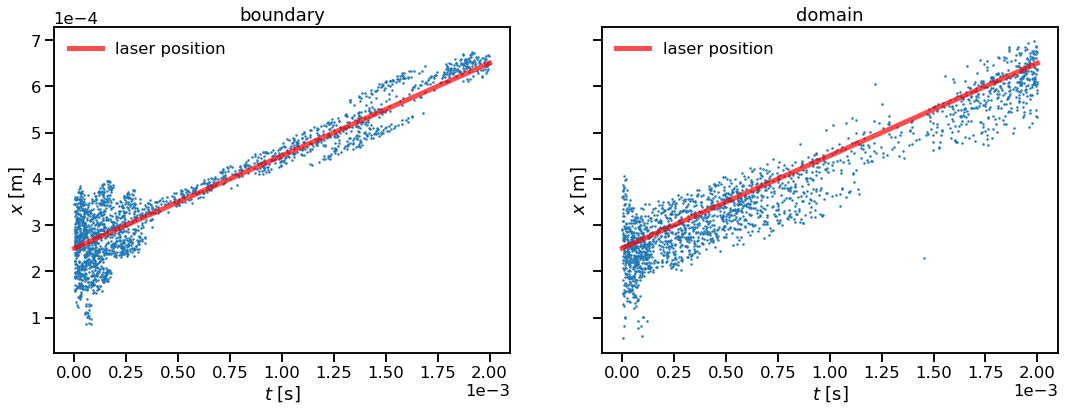

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (18, 6), sharey=True)

#ax1.scatter(points_error_bound.T[3], points_error_bound.T[0], s = 1, c = points_error_bound.T[1])
ax1.scatter(points_error_bound.T[3], points_error_bound.T[0], s = 1)
ax1.plot(np.linspace(0, t_max), x_max/4 + v * np.linspace(0, t_max), 'r-', linewidth = 5, alpha = 0.7, label = 'laser position')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$x$ [m]')
ax1.legend(loc = 'upper left', frameon=False)
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax1.set_title('boundary')

#ax2.scatter(points_error.T[3], points_error.T[0], s = 1, c = points_error.T[1])
ax2.scatter(points_error.T[3], points_error.T[0], s = 1)
ax2.plot(np.linspace(0, t_max), x_max/4 + v * np.linspace(0, t_max), 'r-', linewidth = 5, alpha = 0.7, label = 'laser position')
ax2.set_title('domain')
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.set_xlabel('$t$ [s]')
ax2.legend(loc = 'upper left', frameon=False)
ax2.set_ylabel('$x$ [m]')

plt.savefig('conduct_pics/laser_resample.pdf', bbox_inches='tight')

Adding the points to the traning dataset:

In [22]:
data.add_anchors(points_error)
data.add_anchors(points_error_bound)

## More Training

In [23]:
losshistory, train_state = model.train(display_every=100)

Training model...



2023-02-24 10:22:50.228784: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Step      Train loss              Test loss               Test metric
2293      [5.65e-02, 8.12e-03]    [8.77e-03, 8.12e-03]    []  
2300      [5.42e-02, 8.97e-03]                                
2400      [2.29e-02, 1.68e-02]                                
2500      [1.74e-02, 1.42e-02]                                
2600      [1.42e-02, 1.21e-02]                                
2700      [1.16e-02, 1.04e-02]                                
2800      [1.00e-02, 9.28e-03]                                
2900      [8.75e-03, 8.74e-03]                                
3000      [7.74e-03, 8.12e-03]                                
3100      [7.16e-03, 7.53e-03]                                
3200      [6.54e-03, 7.17e-03]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.012931
  Number of iterations: 907
  Number of functions evaluations: 1001
3294      [5.96e-03, 6

In [24]:
losshistory, train_state = model.train(display_every=100)

Training model...

Step      Train loss              Test loss               Test metric
3294      [5.96e-03, 6.97e-03]    [4.18e-03, 6.97e-03]    []  
3300      [5.96e-03, 6.97e-03]                                
3400      [5.54e-03, 6.82e-03]                                
3500      [5.21e-03, 6.73e-03]                                
3600      [4.79e-03, 6.61e-03]                                
3700      [4.49e-03, 6.44e-03]                                
3800      [4.15e-03, 6.21e-03]                                
3900      [3.72e-03, 6.15e-03]                                
4000      [3.45e-03, 6.08e-03]                                
4100      [3.23e-03, 5.97e-03]                                
4200      [3.04e-03, 5.87e-03]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.008639
  Number of iterations: 913
  Number of functions evaluations: 1001
429

In [28]:
losshistory, train_state = model.train(display_every=100)

Training model...

Step      Train loss              Test loss               Test metric
4295      [2.86e-03, 5.78e-03]    [2.02e-03, 5.78e-03]    []  
4300      [2.86e-03, 5.78e-03]                                
4400      [2.73e-03, 5.71e-03]                                
4500      [2.58e-03, 5.73e-03]                                
4600      [2.49e-03, 5.66e-03]                                
4700      [2.43e-03, 5.58e-03]                                
4800      [2.35e-03, 5.55e-03]                                
4900      [2.28e-03, 5.49e-03]                                
5000      [2.21e-03, 5.42e-03]                                
5100      [2.20e-03, 5.41e-03]                                
5200      [2.13e-03, 5.37e-03]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.007348
  Number of iterations: 841
  Number of functions evaluations: 1001
529

## Post Processing:

Saving model and losses

In [32]:
model.save('final/')

INFO:tensorflow:final/-5296.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'final/-5296.ckpt'

In [25]:
model.restore('final/-5296.ckpt')

INFO:tensorflow:Restoring parameters from final/-5296.ckpt


In [29]:
np.save('losses/final_losses/test_loss.npy', losshistory.loss_test)
np.save('losses/final_losses/train_loss.npy', losshistory.loss_train)
np.save('losses/final_losses/steps', losshistory.steps)

In [12]:
loss_test = np.load('losses/final_losses/test_loss.npy')
loss_train = np.load('losses/final_losses/train_loss.npy')
steps = np.load('losses/final_losses/steps.npy')

Plotting test and train loss

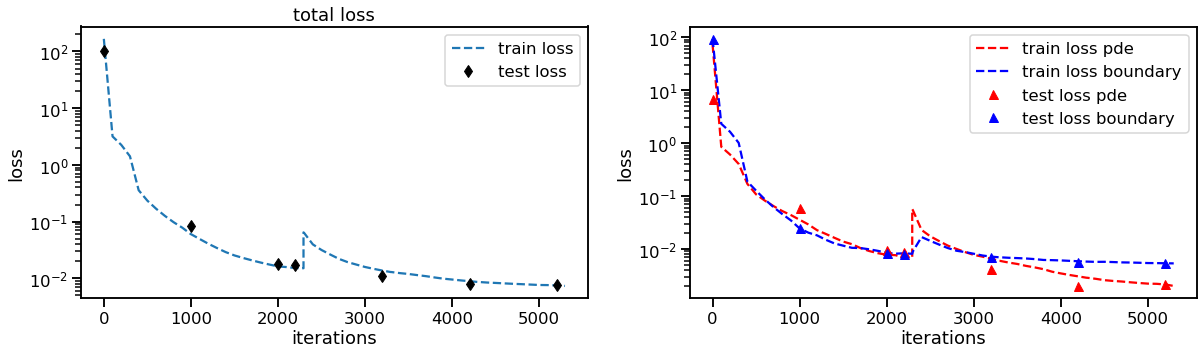

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 5))

net_losses = loss_test.sum(axis=1)[1:]
x_values = steps
values, index = np.unique(net_losses, return_index=True)
index = sorted(index)

ax1.plot(x_values[1:], loss_train.sum(axis=1)[1:], linestyle = '--', label = 'train loss')
ax1.plot(x_values[index], net_losses[index], 'kd', label = 'test loss', alpha = 1)

ax1.set_yscale('log')
#ax1.grid()
ax1.legend()
ax1.set_title('total loss')
ax1.set_ylabel('loss')

ax2.plot(x_values[1:], loss_train.T[0, 1:], '--', label = 'train loss pde', color = 'red')
ax2.plot(x_values[1:], loss_train.T[1, 1:], label = 'train loss boundary', linestyle = '--', color = 'blue')

ax2.plot(x_values[index], loss_test.T[0, 1:][index], 'r^', label = 'test loss pde', alpha = 1)
ax2.plot(x_values[index], loss_test.T[1, 1:][index], 'b^', label = 'test loss boundary', alpha = 1)

ax2.set_yscale('log')
#ax2.grid()
ax2.legend()
ax2.set_ylabel('loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('iterations')
ax1.set_xlabel('iterations')

plt.savefig('conduct_pics/losses.pdf', bbox_inches='tight')

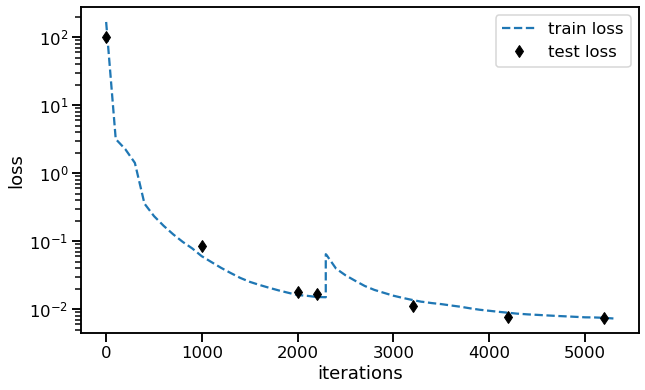

In [15]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 6))

net_losses = loss_test.sum(axis=1)[1:]
x_values = steps
values, index = np.unique(net_losses, return_index=True)
index = sorted(index)

ax1.plot(x_values[1:], loss_train.sum(axis=1)[1:], linestyle = '--', label = 'train loss')
ax1.plot(x_values[index], net_losses[index], 'kd', label = 'test loss', alpha = 1)

ax1.set_yscale('log')
#ax1.grid()
ax1.legend()
ax1.set_ylabel('loss')

ax1.set_xlabel('iterations')

plt.savefig('conduct_pics/total_loss_conduction.pdf', bbox_inches='tight')

## Temperature profiles

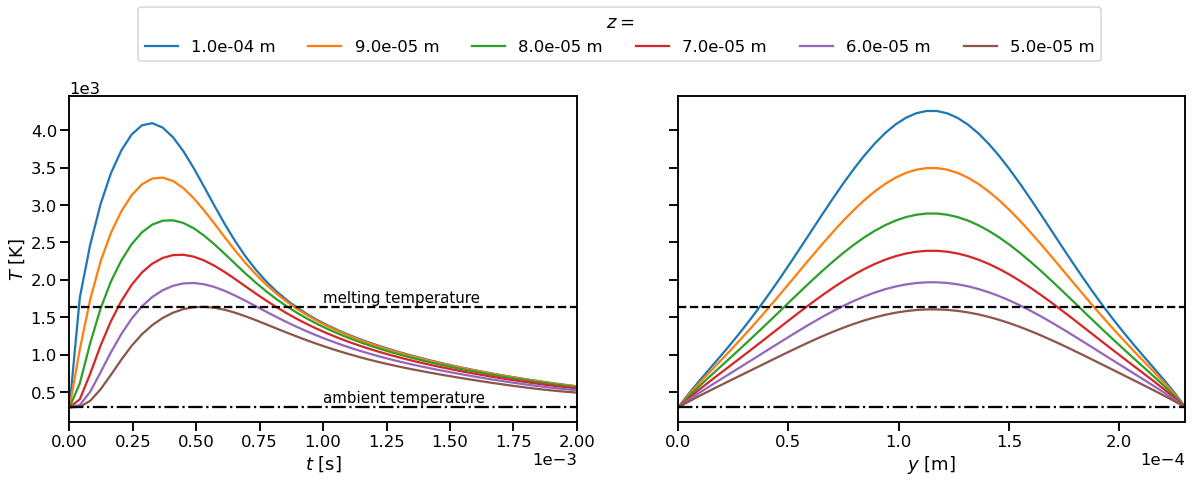

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20, 6), sharey=True)

for i in range(6):
    
    y_test = [y_max/2]
    x_test = [0.3*x_max]
    
    dz = i*z_max*0.1
    
    z_test = [z_max-dz]
    t_test = np.linspace(0, t_max)

    xx, yy, zz, tt = np.meshgrid(x_test, y_test, z_test, t_test)
    test_points = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

    Y = model.predict(test_points)

    ax1.plot(t_test, Y, label = "%.1e m"%(z_max-dz))

    
    y_test = np.linspace(0, y_max)
    x_test = [x_max/4 + t_max*v]
    
    dz = i*z_max*0.1
    
    z_test = [z_max-dz]
    t_test = [t_max]

    xx, yy, zz, tt = np.meshgrid(x_test, y_test, z_test, t_test)
    test_points = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

    Y = model.predict(test_points)

    ax2.plot(y_test, Y, label = '${}$'.format(round(z_max-dz, 6)))

ax1.hlines([1633], xmin=0, xmax=t_max, color = 'black', linestyle='--')
ax1.text(0.001, 1700, 'melting temperature', size = 15)

ax1.hlines([T_0+20], xmin=0, xmax=t_max, color = 'black', linestyle='-.')
ax1.text(0.001, T_0+20+67, 'ambient temperature', size = 15)

ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T$ [K]')
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax1.legend(title='$z =$', ncol=6, bbox_to_anchor = (2.05, 1.3))
#ax1.grid()
ax1.set_xlim([0, t_max])

#ax2.grid()
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.hlines([1633], xmin=0, xmax=t_max, color = 'black', linestyle='--')
ax2.hlines([T_0+20], xmin=0, xmax=t_max, color = 'black', linestyle='-.')
ax2.set_xlim([0, y_max])
ax2.set_xlabel('$y$ [m]')

plt.savefig('conduct_pics/profiles.pdf', bbox_inches='tight')

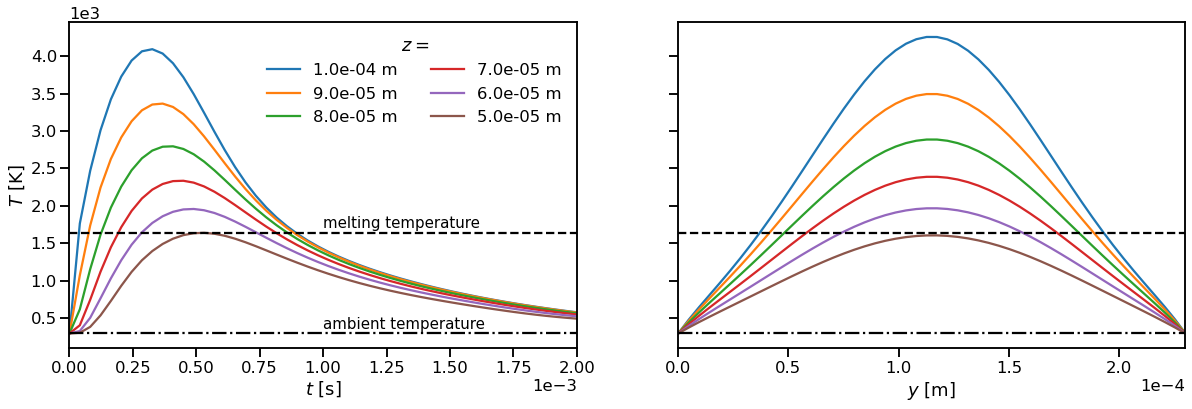

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20, 6), sharey=True)

for i in range(6):
    
    y_test = [y_max/2]
    x_test = [0.3*x_max]
    
    dz = i*z_max*0.1
    
    z_test = [z_max-dz]
    t_test = np.linspace(0, t_max)

    xx, yy, zz, tt = np.meshgrid(x_test, y_test, z_test, t_test)
    test_points = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

    Y = model.predict(test_points)

    ax1.plot(t_test, Y, label = "%.1e m"%(z_max-dz))

    
    y_test = np.linspace(0, y_max)
    x_test = [x_max/4 + t_max*v]
    
    dz = i*z_max*0.1
    
    z_test = [z_max-dz]
    t_test = [t_max]

    xx, yy, zz, tt = np.meshgrid(x_test, y_test, z_test, t_test)
    test_points = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

    Y = model.predict(test_points)

    ax2.plot(y_test, Y, label = '${}$'.format(round(z_max-dz, 6)))

ax1.hlines([1633], xmin=0, xmax=t_max, color = 'black', linestyle='--')
ax1.text(0.001, 1700, 'melting temperature', size = 15)

ax1.hlines([T_0+20], xmin=0, xmax=t_max, color = 'black', linestyle='-.')
ax1.text(0.001, T_0+20+67, 'ambient temperature', size = 15)

ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T$ [K]')
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax1.legend(title='$z =$', ncol=2, frameon=False)
#ax1.grid()
ax1.set_xlim([0, t_max])

#ax2.grid()
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.hlines([1633], xmin=0, xmax=t_max, color = 'black', linestyle='--')
ax2.hlines([T_0+20], xmin=0, xmax=t_max, color = 'black', linestyle='-.')
ax2.set_xlim([0, y_max])
ax2.set_xlabel('$y$ [m]')

plt.savefig('conduct_pics/profiles_conduction.pdf', bbox_inches='tight')

# Temperature fields

XY-Plane, 3 timeframes

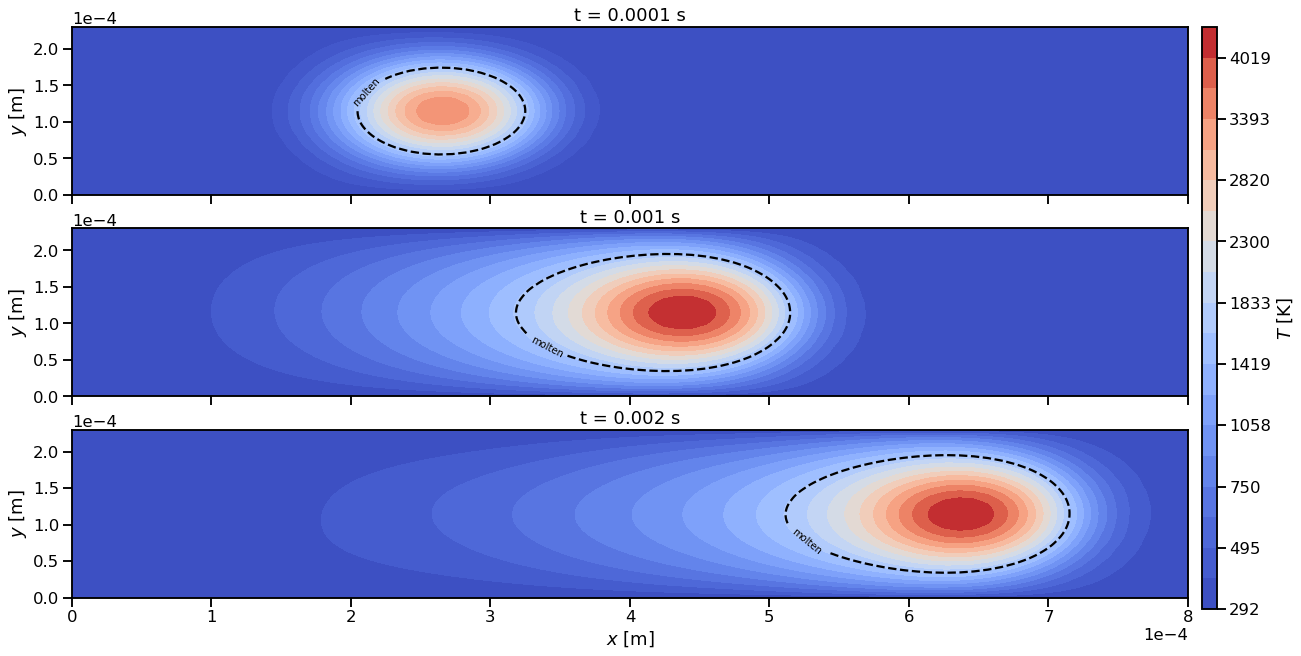

In [28]:
%matplotlib inline

fig, axes = plt.subplots(nrows = 3, figsize = (20, 10.5), sharex=True)
dt = t_max/200

end_data = np.genfromtxt('solidfoam/xy/slice_xy_dat_0.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

for i, ax in zip(reversed([9, 99, 199]), np.flip(axes.flatten())):

    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*dt*(i+1))).T
    Y = model.predict(X)
    T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    if i == 199:
        T_min = T_pred.min()
        T_max = T_pred.max()
    #Plotting

    intervals = np.linspace(np.sqrt(T_pred.min()), np.sqrt(T_pred.max()), 20)**2
    CS = ax.contourf(xi, yi, T_pred, intervals, cmap=plt.cm.coolwarm, vmin = T_min, vmax = T_max)
    CS2 = ax.contour(xi, yi, T_pred, [1633], linestyles='--', colors='black')
    ax.clabel(CS2, inline=True, fontsize=10, fmt=lambda x : 'molten')

    if i == 199:
        
        cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
        fig.colorbar(CS, cax=cbar_ax)
        cbar_ax.set_ylabel('$T$ [K]')
        ax.set_xlabel('$x$ [m]')
        
    ax.set_ylabel('$y$ [m]')
    ax.set_xlim([0, 0.0008])
    ax.set_title('t = {} s'.format(dt*(i+1)))
    ax.ticklabel_format(style='sci',  scilimits=(0, 0))

plt.savefig('conduct_pics/times.pdf', bbox_inches='tight')

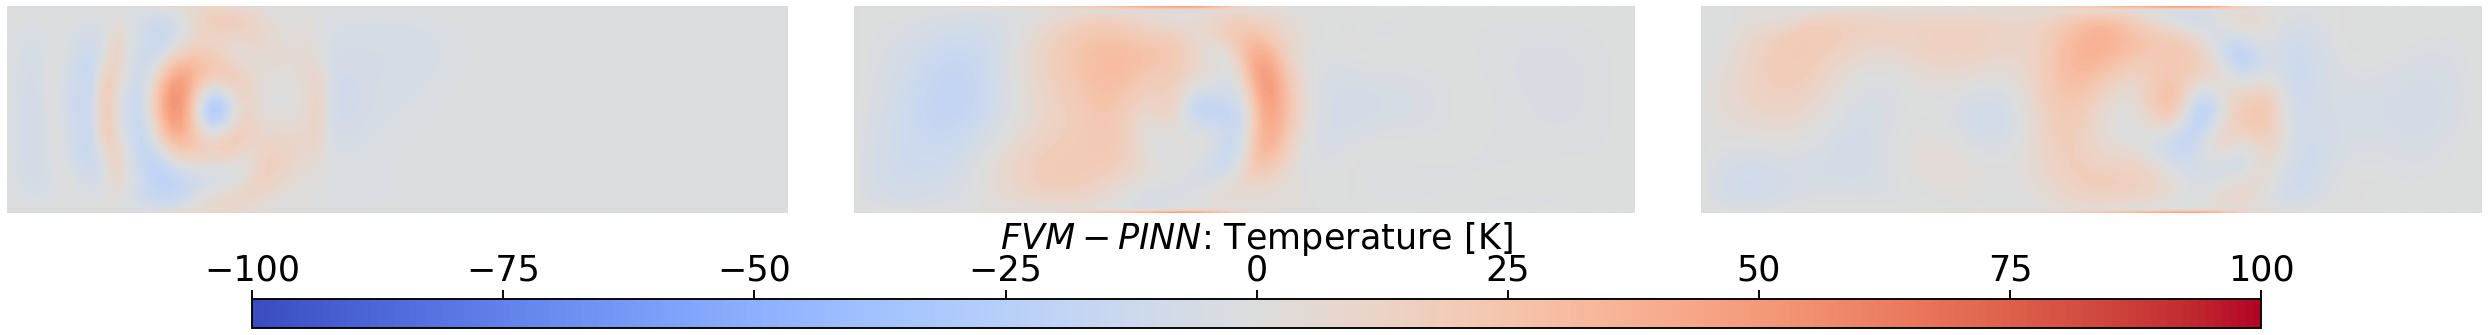

In [75]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('xtick', labelsize=35) 
mpl.rc('ytick', labelsize=35) 
fig, axes = plt.subplots(ncols = 3, figsize = (36, 4), sharey=True)
dt = t_max/200
fig.tight_layout()
for i, ax in zip([9, 99, 199], axes.flatten()):
    
    end_data = np.genfromtxt('solidfoam/xy/slice_xy_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)
    #end_data = np.genfromtxt('of_test/end_slice.csv', delimiter = ',',skip_header = True)
    x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    
    X = np.vstack((x, y, z, np.ones(len(x))*dt*(i+1))).T
    Y = model.predict(X)

    Error_pred = griddata((x, y), T - Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax.contourf(xi, yi, Error_pred, 50, cmap=plt.cm.coolwarm, vmin = -100, vmax = 100)

    if i == 9:
        
        cbar_ax = fig.add_axes([0.125, -0.2, 0.775, 0.1])
        #fig.colorbar(CS, cax=cbar_ax, orientation='horizontal', extend='both')
        fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-100, vmax=100), cmap='coolwarm'), cax=cbar_ax, orientation='horizontal')   
       
    #ax.set_xlabel('$x$[m]')
    ax.axis('off') 
    #ax.set_ylabel('$y$[m]')
    #ax.set_xlim([0, 0.0008])
    #ax.set_title('t = {}s'.format(dt*(i+1)))
    ax.ticklabel_format(style='sci',  scilimits=(0, 0))
cbar_ax.set_xlabel('$FVM-PINN$: Temperature [K]', size = 35)
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.xaxis.set_ticks_position('top')
plt.savefig('conduct_pics/vgl.png', bbox_inches='tight')

### Melting pool attributes

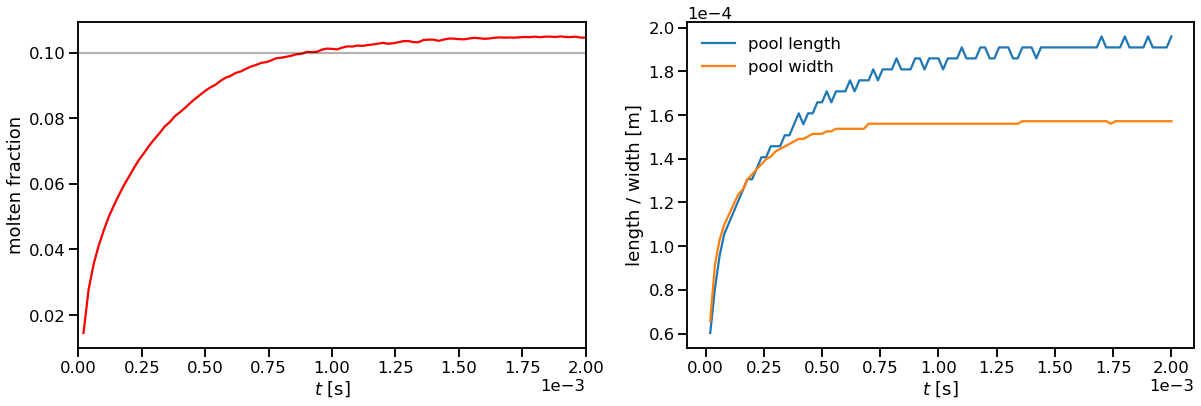

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 6))

fractions = []
lengths = []
widths = []
times = np.linspace(0.00002, t_max, 100)
N = 200
for time in times:
    
    x_lin = np.linspace(0, x_max, N)
    y_lin = np.linspace(0, y_max, N)
    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [time])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)
    mask = Y > 1693
    
    fractions.append(len(Y[mask])/len(Y))
    lengths.append(np.ravel(xx)[mask.T[0]].max()- np.ravel(xx)[mask.T[0]].min())
    widths.append(np.ravel(yy)[mask.T[0]].max()- np.ravel(yy)[mask.T[0]].min())
    
    
ax1.plot(times, fractions, 'r-')
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'molten fraction')
ax1.ticklabel_format(style='sci', scilimits=(0, 0), axis='x')
ax1.hlines([0.1], 0, t_max, color='black', alpha = 0.3)
ax1.set_xlim([0, t_max])

ax2.plot(times, lengths, label = 'pool length')
ax2.plot(times, widths, label = 'pool width')
ax2.ticklabel_format(style='sci', scilimits=(0, 0), axis='both')
ax2.legend( frameon=False)
ax2.set_ylabel(r'length / width [m]')
ax2.set_xlabel(r'$t$ [s]')
plt.savefig('conduct_pics/pool_viz.pdf', bbox_inches='tight')

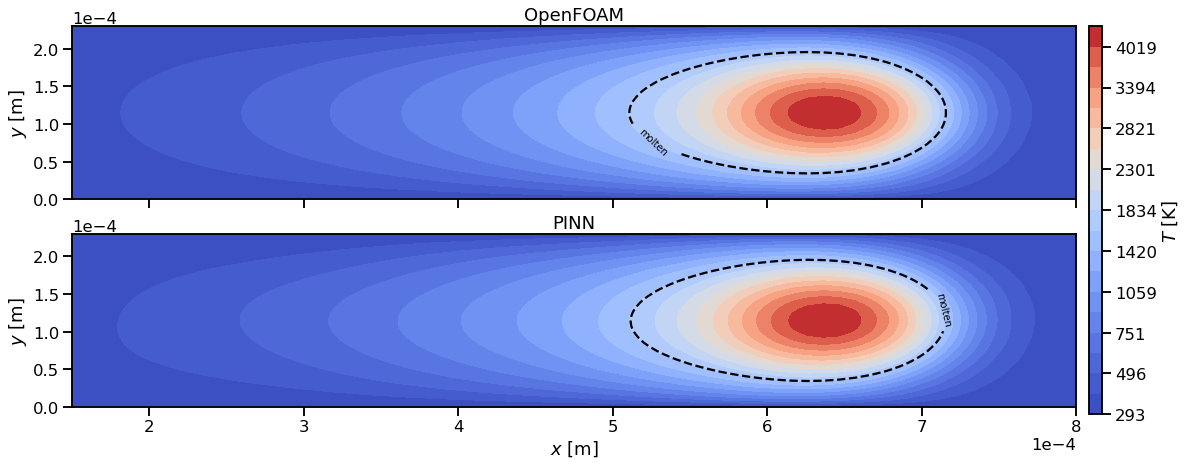

In [30]:
%matplotlib inline

i = 199
dt = t_max/200
end_data = np.genfromtxt('solidfoam/xy/slice_xy_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)

x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*dt*(i+1))).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

#Plotting

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

intervals = np.linspace(np.sqrt(Ti.min()), np.sqrt(T_pred.max()), 20)**2

im = ax1.contourf(xi, yi, Ti, intervals, cmap=plt.cm.coolwarm, vmin = Ti.min(), vmax = T_pred.max())
CS = ax2.contourf(xi, yi, T_pred, intervals, cmap=plt.cm.coolwarm, vmin = Ti.min(), vmax = T_pred.max())

im2 = ax1.contour(xi, yi, Ti, [1633], linestyles='--', colors='black')
CS2 = ax2.contour(xi, yi, T_pred, [1633], linestyles='--', colors='black')


ax1.clabel(im2, inline=True, fontsize=10, fmt=lambda x : 'molten')
ax2.clabel(CS2, inline=True, fontsize=10, fmt=lambda x : 'molten')

ax1.set_ylabel('$y$ [m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('$y$ [m]')
ax2.set_xlabel('$x$ [m]')
ax2.set_title('PINN')
ax2.set_xlim([0.00015, 0.0008])
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('$T$ [K]')
plt.savefig('conduct_pics/xy_contour.pdf', bbox_inches='tight')
plt.show()

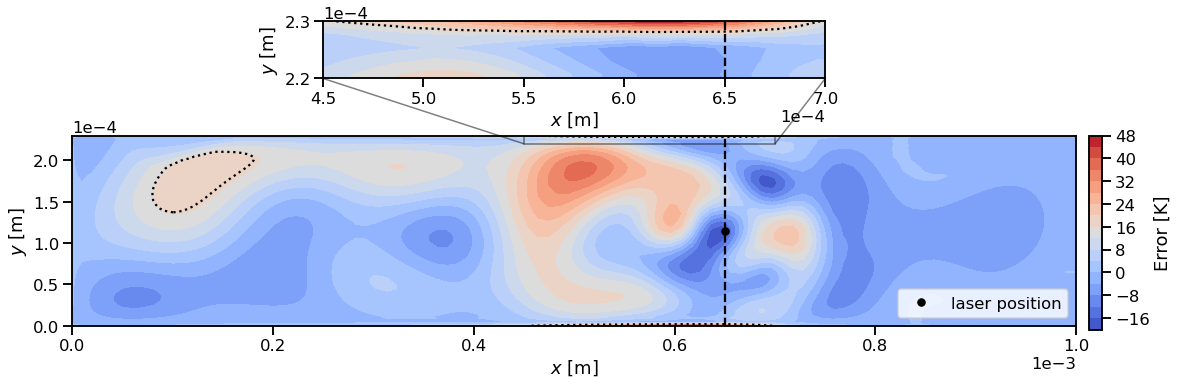

In [31]:
fig, ax = plt.subplots(figsize = (18, 3.5))

im = ax.contourf(xi, yi, (Ti - T_pred), 20, cmap=plt.cm.coolwarm)
im2 = ax.contour(xi, yi, np.abs(Ti - T_pred)/Ti, [0.05], linestyles=':', colors='black')
ax.set_ylabel('$y$ [m]')
ax.set_xlabel('$x$ [m]')
ax.plot([x_max/4 + t_max*v], [y_max/2], 'k.', markersize = 15, label = 'laser position')
ax.vlines([x_max/4 + t_max*v], 0, y_max, linestyle = '--', color = 'black')
# inset axes....
axins = ax.inset_axes([0.25, 1.3, 0.5, 0.3])
axins.contourf(xi, yi, (Ti - T_pred), 20, cmap=plt.cm.coolwarm)
im2 = axins.contour(xi, yi, np.abs(Ti - T_pred)/Ti, [0.05], linestyles=':', colors='black')
axins.vlines([x_max/4 + t_max*v], 0.00022, y_max, linestyle = '--', color = 'black')
# subregion of the original image
x1, x2, y1, y2 = (0.00045, 0.0007, 0.00022, y_max)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_ylabel('$y$ [m]')
axins.set_xlabel('$x$ [m]')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.ticklabel_format(style='sci',  scilimits=(0, 0))
axins.ticklabel_format(style='sci',  scilimits=(0, 0))

cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(im, cax=cbar_ax, label = 'Error [K]')

ax.legend(loc = 'lower right')
plt.savefig('conduct_pics/xy-error.pdf', bbox_inches='tight')
plt.show()

In [32]:
x = np.linspace(0, x_max)
y = [y_max]
t = [t_max]
z = [z_max]

xx, yy, zz, tt = np.meshgrid(x, y, z, t)
X = np.vstack([xx.flatten(), yy.flatten(), zz.flatten(), tt.flatten()]).T
Y = model.predict(X)[:,0]

end_data = np.genfromtxt('solidfoam/xy/slice_xy_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)

x_load, y_load, z_load, T_load = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
x_load, y_load, z_load, T_load = x_load[y_load == y[0]], y_load[y_load == y[0]], z_load[y_load == y[0]], T_load[y_load == y[0]]

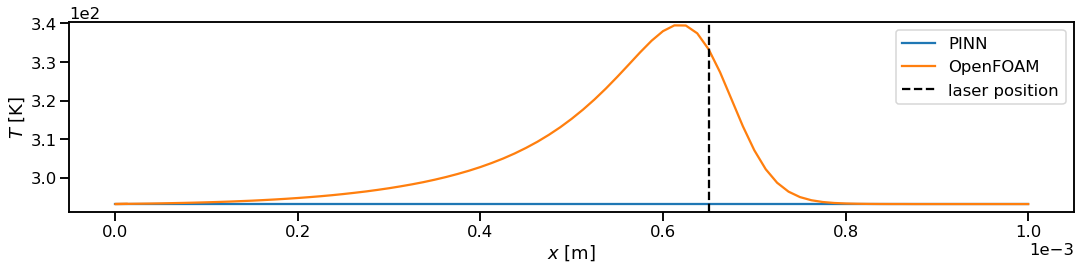

In [33]:
fig, ax = plt.subplots(figsize = (18, 3.5))

ax.plot(x, Y, label = 'PINN')
ax.plot(x_load, T_load, label = 'OpenFOAM')
ax.vlines([x_max/4 + t_max*v], T_load.min()-2,T_load.max()+1, linestyle = '--', color = 'black', label = 'laser position')
plt.legend()

ax.ticklabel_format(style='sci',  scilimits=(0, 0))
ax.set_ylabel('$T$ [K]')
ax.set_xlabel('$x$ [m]')
ax.set_ylim((T_load.min()-2, T_load.max()+1))

plt.savefig('conduct_pics/systematic.pdf', bbox_inches='tight')

# Whole time series

In [34]:
error_mean_no = []
error_max_no = []

error_mean = []
error_max = []
T_series = []

dt = t_max/200

model.restore('final/no_resample-2293.ckpt')
for i in range(200):
    end_data = np.genfromtxt('solidfoam/xy/slice_xy_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)
    
    #end_data = np.genfromtxt('of_test/end_slice.csv', delimiter = ',',skip_header = True)
    x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

    X = np.vstack((x, y, z, np.ones(len(x))*dt*(i+1))).T
    Y = model.predict(X)

    error_mean_no.append((np.abs(Y[:,0] - T)/T).mean())
    error_max_no.append((np.abs(Y[:,0] - T)/T).max())
    
model.restore('final/-5296.ckpt')
for i in range(200):
    end_data = np.genfromtxt('solidfoam/xy/slice_xy_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)
    
    #end_data = np.genfromtxt('of_test/end_slice.csv', delimiter = ',',skip_header = True)
    x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

    X = np.vstack((x, y, z, np.ones(len(x))*dt*(i+1))).T
    Y = model.predict(X)
    T_series.append(T.max())
    error_mean.append((np.abs(Y[:,0] - T)/T).mean())
    error_max.append((np.abs(Y[:,0] - T)/T).max())

INFO:tensorflow:Restoring parameters from final/no_resample-2293.ckpt
INFO:tensorflow:Restoring parameters from final/-5296.ckpt


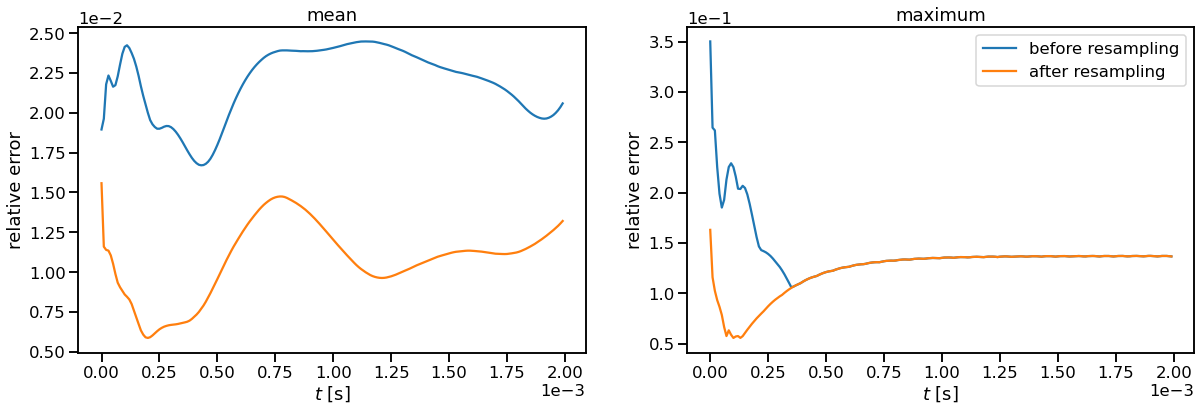

In [35]:
fig, (ax1, ax2)=plt.subplots(ncols = 2, figsize = (20, 6))

ax2.set_title('maximum')
ax2.plot(np.arange(0, t_max, dt), error_max_no, label = 'before resampling')
ax2.plot(np.arange(0, t_max, dt), error_max, label = 'after resampling')

ax2.set_ylabel('relative error')
ax2.legend(loc= 'upper right', frameon=True)
#ax2.legend(frameon=True, ncol=1, bbox_to_anchor=(0.3,-0.15))

ax2.ticklabel_format(style='sci', scilimits=(0, 0))
ax2.set_xlabel('$t$ [s]')

ax1.set_title('mean')
ax1.plot(np.arange(0, t_max, dt), error_mean_no, label = 'before resampling')
ax1.plot(np.arange(0, t_max, dt), error_mean, label = 'after resampling')
#ax1.plot(np.arange(0, t_max, dt), 0.02*np.array(T_series)/np.array(T_series).max())
ax1.set_ylabel('relative error')
#ax1.set_xlabel('')
#ax1.legend(frameon=False)
ax1.ticklabel_format(style='sci', scilimits=(0, 0))
ax1.set_xlabel('$t$ [s]')

plt.savefig('conduct_pics/errors.pdf', bbox_inches='tight')